**RANDOM FOREST - ROC-AUC - hERG - QSAR** 

Preparation Steps to get the data into a form acceptable that can be understood by machine learning model. Depending on the initial data set, there may be extra work involved such as : one-hot encode categorical variables, converte to arrays, removing outliers, imputing missing values, converting temporal varaibles into cyclical repressentations. 

**Step 1 : Import modules** 

In [26]:
import pandas as pd                                                   # to load pandas used for data manipulation
import numpy as np                                                    # to load numpy 
from sklearn.ensemble import RandomForestClassifier                   # to build a random forest classifier 
from sklearn.model_selection import train_test_split                  # to split the dataset

from sklearn.metrics import matthews_corrcoef                         # to load mathew correlation coefficient score 

from sklearn.metrics import roc_curve                                 # to draw roc curve
import matplotlib.pyplot as plt                                       # ...
from sklearn.metrics import roc_auc_score                             # to determine ROC-AUC score

from sklearn.model_selection import KFold                             # to crate folds and perform Cross-Validation
from joblib import dump, load                                         # to save binary object as the models
                    

**Step 2 : Import the training dataset** 

In [14]:
df = pd.read_csv('Dataframe without picks.csv') # to download the data from the file into a dataframe called df
df.head()                                       # to view the top 5 rows 

,Unnamed: 0,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,0,Cc1c(C(O)CN2CCC3(CC2)CC(=O)N(c2ccc(S(C)(=O)=O)...,499.177707,0.621282,1.914286,117.11,8.0,1.0,2.01642,0.480000,...,0,4.689620,AABBLHFMQYNECK-UHFFFAOYSA-N,False,False,False,NaN,1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0
1,1,COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CC2CCN(C(C)=O)CC2...,452.219033,0.640655,1.903226,97.13,6.0,2.0,2.00840,0.636364,...,0,NaN,AACMOCSSQXOERG-UHFFFAOYSA-N,False,False,False,NaN,-1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,1
2,3,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,438.208947,0.618469,1.870968,61.61,6.0,1.0,4.39020,0.500000,...,1,5.675718,AAELEHAFAYIZRH-UHFFFAOYSA-N,False,False,False,NaN,5,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,3
3,7,CCN1CCN(CC(=O)Nc2ccc(-c3cccc4c(=O)cc(N5CCOCC5)...,582.230077,0.293449,1.642857,78.26,8.0,1.0,5.24050,0.333333,...,0,NaN,AATCBLYHOUOCTO-UHFFFAOYSA-N,False,False,False,NaN,8,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,7
4,8,CCCN1C(=O)CC2(CCN(CC3CCN(C(=O)OCC)CC3)CC2)c2cc...,428.278741,0.718882,1.935484,65.98,5.0,0.0,3.43040,0.708333,...,1,6.173925,AATNRUXRJQIOEV-UHFFFAOYSA-N,False,False,False,NaN,1,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,8


**Step 3 : Build a Random Forest model** 

A 10 Fold Cross-Validation is performed to obtain 10 models. 

In [23]:

dict_ytrain_pred = {}         # to store results into dictionaries
dict_yeval_pred = {}



# 1) To define the descriptors and the outcome.
X = df[['ExactMolWt','qed','FpDensityMorgan2','TPSA','NumHAcceptors','NumHDonors','MolLogP','FractionCSP3','NumRotatableBonds','HeavyAtomCount', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles','NumAromaticHeterocycles','NumAromaticRings']]
Y = df['Outcome']



# 2) To create 10 folds.
kf = KFold(n_splits=10)                                     
KFold(n_splits=10, random_state=None, shuffle=False)



# 3) To loop over each fold corresponding to a model.
for fold, (train_index, eval_index) in enumerate(kf.split(X,Y)):            
    print("fold n°{}".format(fold))  



    # 3.1) To split the dataset into training and evaluation set.    
    X_train, X_eval = X.take(list(train_index),axis=0), X.take(list(eval_index),axis=0)   
    y_train, y_eval = Y.take(list(train_index),axis=0), Y.take(list(eval_index),axis=0)



    # 3.2) To build a forest of trees from the training set(X,y).
    rf = RandomForestClassifier(n_estimators=600, bootstrap=True, max_depth=40, max_features=4, min_samples_leaf=2, min_samples_split=10,ccp_alpha=0.001419, random_state=50, n_jobs=-1) 
    trained_rf = rf.fit(X_train, y_train)                  # to fit the model to the training data set   



    # 3.3) To evaluate the model.
    ytrain_pred = rf.predict_proba(X_train)                   
    dict_ytrain_pred[fold] = ytrain_pred                                                  # to add the result into a dictionary
    print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))        # to print the results

    yeval_pred = rf.predict_proba(X_eval)
    dict_yeval_pred[fold] = yeval_pred 
    print('RF eval roc-auc: {}'.format(roc_auc_score(y_eval, yeval_pred[:,1])))

    # to pickel the model to disk
    dump(trained_rf, 'rf_model_fold{}.joblib'.format(fold))    

    

    # 3.4) To select the best threshold of the model for the maximum mathew correlation coefficient (MCC).
    model = load('rf_model_fold{}.joblib'.format(fold))       # to load the model 


    # A. To obtain the predicted probabilities.
    prob=[]                                                                                        # a list containing all the predicted probabilities of the model{fold}
    prob.append(pd.Series(model.predict_proba(X_eval)[:,1]))                                       # to predict the mean probability for all the models by concatinating the prob list
    final_prob=pd.concat(prob,axis=1)                                                              # to obtain for a sample the mean, average probability of all the models
    print('Average eval roc-auc: {}'.format(roc_auc_score(y_eval,final_prob))) 
    #pd.concat(prob, axis=1)   # to understand line 3 of the above code block : calculate the mean of every line and store it in final_prob -> not necessary because we check at every loop a single model.
    

    # B. To create the tresholds values.
    fpr, tpr, thresholds = roc_curve(y_eval, final_prob)         # fpr : false positive rate, tpr : true positive rate
    
    
    # C. To calculate the MCC score corresponding to a treshold value.
    MCC_list = []                                                     # a list containing for every sample his corresponding mcc score
    for threshold in thresholds:
        y_pred = np.where(final_prob>threshold,1,0)                   # if the mean probability of the sample is superior as the thresholds value than it corresponds to the class 1, else to 0
        MCC_list.append(matthews_corrcoef(y_eval, y_pred))            # to calculate the mcc score of y_pred (list composed of 0 and 1 obtained at the line above )
        

    # D. To create a data frame sorting the MCC values per ascending order. (1st place = max mcc score)
    MCC = pd.concat([pd.Series(thresholds), pd.Series(MCC_list)],     
                        axis=1)
    MCC.columns = ['thresholds', 'MCC']
    MCC.sort_values(by='MCC', ascending=False, inplace=True)
    print(f'Threshold fold{fold}: {MCC.head()}')  # to look at the head of the datframe showing the max MCC score and his corresponding threshold
    threshold_value = MCC.loc[MCC['MCC'] == MCC['MCC'].max(), 'thresholds'].iloc[0]  # to identify the treshold value of the model 
    print(f'Threshold = {threshold}')

    # E. To pickel the threshold to disk.
    dump(threshold_value, 'threshold_fold{}.joblib'.format(fold)) 

    # and the dataframe.

    dump(MCC,'MCC_fold{}.joblib'.format(fold))


fold n°0
RF train roc-auc: 0.9703204281113442
RF eval roc-auc: 0.7529644268774704
Average eval roc-auc: 0.7529644268774704
Threshold fold0:     thresholds       MCC
50    0.397236  0.421631
49    0.400720  0.419461
47    0.401986  0.417552
46    0.422294  0.415894
48    0.401665  0.407013
Threshold = 0.079978833202142
fold n°1
RF train roc-auc: 0.9710103399502512
RF eval roc-auc: 0.7542948955629711
Average eval roc-auc: 0.7542948955629711
Threshold fold1:     thresholds       MCC
8     0.705747  0.423692
10    0.674218  0.412674
9     0.687760  0.398638
13    0.646210  0.392995
27    0.548039  0.390321
Threshold = 0.09891619442483886
fold n°2
RF train roc-auc: 0.9712156524416546
RF eval roc-auc: 0.7782738095238096
Average eval roc-auc: 0.7782738095238096
Threshold fold2:     thresholds       MCC
34    0.520714  0.436769
33    0.546349  0.428571
27    0.555398  0.426148
29    0.552324  0.423368
35    0.504945  0.423164
Threshold = 0.11720702245372898
fold n°3
RF train roc-auc: 0.9708703

In [22]:
final_prob

,0
0,0.872828
1,0.363740
2,0.639605
3,0.279279
4,0.418675
...,...
175,0.132336
176,0.250120
177,0.618771
178,0.304065


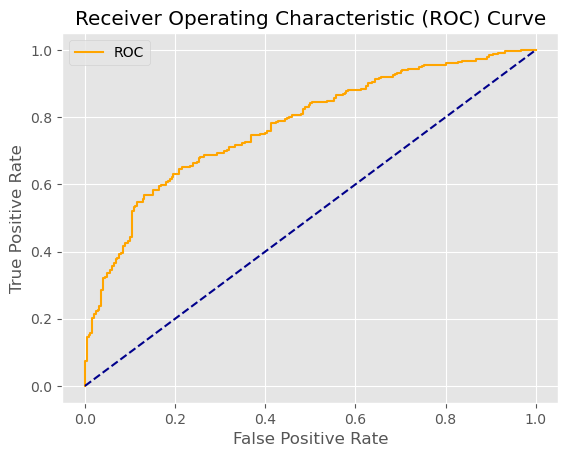

In [16]:
# to plot ROC curve 
plt.style.use('ggplot') # to set plotting style

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr,tpr)

**Step 4 : Import the testing dataset** 

In [42]:
df = pd.read_csv('Dataframe with picks.csv') # to download the data from the file into a dataframe called df
df.head()                                       # to view the top 5 rows 

,Unnamed: 0,SMILES_new,ExactMolWt,qed,FpDensityMorgan2,TPSA,NumHAcceptors,NumHDonors,MolLogP,FractionCSP3,...,Outcome,pIC50,InChIKey,desalted\demetalled,mixture,complex,changes,Clusters,fingerprint,ID
0,2,Cc1cc(C)n(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n...,368.196074,0.719563,1.962963,89.08,7.0,1.0,2.73776,0.368421,...,1,6.187087,AACWUFIIMOHGSO-UHFFFAOYSA-N,False,False,False,NaN,2,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
1,4,Cc1ccc(NC(=O)C(COC(C)C)Oc2ncnc3c2cnn3-c2ncccc2...,467.147265,0.418807,2.000000,116.94,9.0,1.0,3.37842,0.272727,...,0,NaN,AAGISEXHOPCAHZ-UHFFFAOYSA-N,False,False,False,NaN,4,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
2,5,Cc1ncoc1-c1nnc(SCCCN2CCC3(CC3c3ccccc3)C2)n1C,409.193631,0.431725,2.103448,59.98,7.0,0.0,4.14032,0.500000,...,1,5.420000,AAPXNHMQKBDDJN-UHFFFAOYNA-N,False,False,False,NaN,5,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
3,6,CN(C)Cc1ccc(C(F)(F)F)cc1Oc1ccc(Cl)c(Cl)c1,363.040454,0.673225,1.695652,12.47,2.0,0.0,5.86610,0.250000,...,1,5.950782,AAQZZAVVFRIEOD-UHFFFAOYSA-N,False,False,False,NaN,6,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS
4,10,O=C(Cc1ccc(-n2cnnn2)cc1)N1CCN(CCc2ccc3c(c2)COC...,418.211724,0.605615,1.709677,76.38,7.0,0.0,1.62190,0.391304,...,1,5.602060,AAYRYIFNKRSGOF-UHFFFAOYSA-N,False,False,False,NaN,7,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,PICKS


In [44]:
df.shape

(1800, 30)

In [31]:
X = df[['ExactMolWt','qed','FpDensityMorgan2','TPSA','NumHAcceptors','NumHDonors','MolLogP','FractionCSP3','NumRotatableBonds','HeavyAtomCount', 'NumAliphaticCarbocycles', 'NumAromaticCarbocycles', 'NumAliphaticHeterocycles','NumAromaticHeterocycles','NumAromaticRings']]
y = df['Outcome']

In [32]:

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [33]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
ytrain_pred = rf_model.predict_proba(X_train)
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
ytest_pred = rf_model.predict_proba(X_test)
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))

RF train roc-auc: 0.9999987401574804
RF test roc-auc: 0.8076601174469019


In [34]:
# 1) To load the models.

model0 = load('rf_model_fold0.joblib')  
model1 = load('rf_model_fold1.joblib')
model2 = load('rf_model_fold2.joblib')
model3 = load('rf_model_fold3.joblib')
model4 = load('rf_model_fold4.joblib')
model5 = load('rf_model_fold5.joblib')
model6 = load('rf_model_fold6.joblib')
model7 = load('rf_model_fold7.joblib')
model8 = load('rf_model_fold8.joblib')
model9 = load('rf_model_fold9.joblib')

In [49]:
pred=[]     # a list containing all the predicted probabilities 
for model in [model0, model1, model2,model3 ,model4 , model5, model6, model7, model8, model9]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))                                           # to obtain the predicted probabilities
tablepred=pd.concat(pred,axis=1)
    #threshold = load('threshold_fold{}.joblib'.format(fold))   # to load the tuned treshold corresponding to the model 


In [50]:
tablepred

,0,1,2,3,4,5,6,7,8,9
0,0.157239,0.161771,0.162552,0.141765,0.200880,0.187919,0.170736,0.190564,0.244397,0.209554
1,0.520236,0.442138,0.686701,0.476366,0.475232,0.493233,0.528750,0.510306,0.528262,0.470364
2,0.239733,0.242910,0.236957,0.337648,0.283948,0.261473,0.260462,0.237682,0.235892,0.253656
3,0.129787,0.136103,0.165131,0.126393,0.112595,0.138610,0.111646,0.226183,0.116830,0.133335
4,0.179066,0.186179,0.173516,0.158959,0.175971,0.225271,0.168814,0.187148,0.164608,0.186441
...,...,...,...,...,...,...,...,...,...,...
535,0.216547,0.197462,0.233687,0.299529,0.233309,0.210169,0.233957,0.229938,0.205726,0.234425
536,0.315150,0.332293,0.339627,0.340193,0.388143,0.323127,0.530072,0.323524,0.321324,0.365530
537,0.855167,0.836327,0.781099,0.835455,0.819670,0.840695,0.817295,0.777085,0.834175,0.814284
538,0.294282,0.431482,0.454161,0.504134,0.538837,0.504715,0.553225,0.488651,0.456299,0.489491


In [ ]:
pred=[]     # a list containing all the predicted probabilities 
for model in [model0, model1, model2,model3 ,model4 , model5, model6, model7, model8, model9]:
    pred.append(pd.Series(model.predict_proba(X_test)[:,1]))                                           # to obtain the predicted probabilities

    threshold = load('threshold_fold{}.joblib'.format(fold))   # to load the tuned treshold corresponding to the model 

In [40]:
pred

[0      0.157239
 1      0.520236
 2      0.239733
 3      0.129787
 4      0.179066
          ...   
 535    0.216547
 536    0.315150
 537    0.855167
 538    0.294282
 539    0.721585
 Length: 540, dtype: float64,
 0      0.161771
 1      0.442138
 2      0.242910
 3      0.136103
 4      0.186179
          ...   
 535    0.197462
 536    0.332293
 537    0.836327
 538    0.431482
 539    0.700166
 Length: 540, dtype: float64,
 0      0.162552
 1      0.686701
 2      0.236957
 3      0.165131
 4      0.173516
          ...   
 535    0.233687
 536    0.339627
 537    0.781099
 538    0.454161
 539    0.677937
 Length: 540, dtype: float64,
 0      0.141765
 1      0.476366
 2      0.337648
 3      0.126393
 4      0.158959
          ...   
 535    0.299529
 536    0.340193
 537    0.835455
 538    0.504134
 539    0.749992
 Length: 540, dtype: float64,
 0      0.200880
 1      0.475232
 2      0.283948
 3      0.112595
 4      0.175971
          ...   
 535    0.233309
 536    0.388